# Cross-Representation Neighborhood Dissonance (CRND) + Schoener's D Ecological Niche Overlap

**Experiment:** Computes 3 feature spaces (TF-IDF, sentence-transformer embeddings, LLM zero-shot probabilities), per-instance CRND scores at various k-values, KDE-based niche overlap matrices, per-class CRND analysis with statistical tests, and noise detection benchmarks.

**This notebook:**
1. Loads precomputed experiment results (6 clinical datasets, 1707 instances total)
2. Re-computes CRND on a small demo subset to show the methodology live
3. Visualizes key findings: CRND distributions, Schoener's D heatmaps, per-class analysis, and noise detection benchmarks

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# Core packages (pre-installed on Colab, install locally to match Colab env)
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scikit-learn==1.6.1', 'scipy==1.16.3',
         'matplotlib==3.10.0', 'seaborn==0.13.2', 'tqdm==4.67.3')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json
import os
import warnings
from collections import Counter
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy, gaussian_kde, kruskal, mannwhitneyu, spearmanr
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

print("All imports successful.")

All imports successful.


## Data Loading

Load precomputed experiment results from `mini_demo_data.json`. This contains:
- **Metadata**: Aggregate results across all 6 clinical datasets (CRND summaries, niche overlap matrices, per-class analysis, noise detection benchmarks, cross-dataset generalization)
- **Examples**: 75 medical abstracts from the `medical_abstracts` dataset (5 classes, 15 per class) with precomputed CRND scores

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e0166a-cross-representation-neighborhood-disson/main/experiment_iter6_cross_represent/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()

meta = data["metadata"]
datasets_used = meta["datasets_used"]
per_ds_agg = meta["per_dataset_aggregate"]

# Extract demo examples
demo_ds = data["datasets"][0]
examples = demo_ds["examples"]
texts = [ex["input"] for ex in examples]
labels = [ex["output"] for ex in examples]

print(f"Loaded {len(examples)} examples from '{demo_ds['dataset']}' dataset")
print(f"Classes: {sorted(set(labels))}")
print(f"Full experiment processed {meta['n_datasets']} datasets: {datasets_used}")
print(f"Runtime: {meta['runtime_seconds']:.0f}s, LLM calls: {meta['llm_total_calls']}, Cost: ${meta['llm_total_cost_usd']:.4f}")

Loaded 75 examples from 'medical_abstracts' dataset
Classes: ['Cardiovascular_diseases', 'Digestive_system_diseases', 'General_pathological_conditions', 'Neoplasms', 'Nervous_system_diseases']
Full experiment processed 6 datasets: ['medical_abstracts', 'mimic_iv_ed_demo', 'ohsumed_single', 'mental_health_conditions', 'medical_abstracts_v2', 'medical_transcriptions']
Runtime: 3185s, LLM calls: 801, Cost: $0.0153


## Configuration

Tunable parameters for the live CRND re-computation demo. The notebook uses a small subset of examples to demonstrate the methodology in real-time.

In [5]:
# ── Config: Live CRND re-computation parameters ─────────────────────
# These match the original experiment values where possible.
# The demo runs on 75 examples (vs 300 in the full experiment).

K_VALUES = [5, 10, 20]        # Original: [5, 10, 20]
MAX_TFIDF_FEATURES = 5000     # Original: 5000
GRID_SIZE = 80                # Original: 80 (Schoener's D KDE grid)
N_EXAMPLES = 75               # Number of demo examples to process (max = len(examples))
NOISE_RATES = [0.05, 0.10, 0.20]  # Original: [0.05, 0.10, 0.20]
N_NOISE_SEEDS = 3             # Original: 3

print(f"Config: K_VALUES={K_VALUES}, MAX_TFIDF_FEATURES={MAX_TFIDF_FEATURES}, "
      f"GRID_SIZE={GRID_SIZE}, N_EXAMPLES={N_EXAMPLES}")

Config: K_VALUES=[5, 10, 20], MAX_TFIDF_FEATURES=5000, GRID_SIZE=80, N_EXAMPLES=75


## Phase 1: Feature Space Construction

Build three feature representations for the demo subset:
1. **TF-IDF**: Sparse bag-of-words with sublinear TF, bigrams
2. **SVD Embeddings**: Dense vectors via TruncatedSVD on TF-IDF (proxy for sentence-transformer embeddings — the full experiment uses `all-MiniLM-L6-v2`)
3. **LLM Proxy**: Cross-validated logistic regression predictions (proxy for LLM zero-shot probabilities)

In [6]:
import time

# Prepare data subset
demo_texts = texts[:N_EXAMPLES]
demo_labels = labels[:N_EXAMPLES]
unique_labels = sorted(set(demo_labels))
label_to_int = {l: i for i, l in enumerate(unique_labels)}
labels_int = np.array([label_to_int[l] for l in demo_labels])
n_classes = len(unique_labels)

print(f"Processing {len(demo_texts)} examples, {n_classes} classes")
print(f"Class distribution: {dict(Counter(demo_labels))}")

# ── TF-IDF Features ──
t0 = time.time()
vectorizer = TfidfVectorizer(
    max_features=MAX_TFIDF_FEATURES,
    sublinear_tf=True,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2),
    stop_words="english",
)
X_tfidf_sparse = vectorizer.fit_transform(demo_texts)
X_tfidf = X_tfidf_sparse.toarray()
print(f"TF-IDF: shape {X_tfidf.shape} ({time.time()-t0:.1f}s)")

# ── SVD Embeddings (proxy for sentence-transformer) ──
# Full experiment uses all-MiniLM-L6-v2 (384-dim); we approximate with TruncatedSVD
t0 = time.time()
n_svd_components = min(100, X_tfidf_sparse.shape[1] - 1, X_tfidf_sparse.shape[0] - 1)
svd = TruncatedSVD(n_components=n_svd_components, random_state=42)
X_embed = normalize(svd.fit_transform(X_tfidf_sparse))
print(f"SVD Embeddings: shape {X_embed.shape}, explained_var={svd.explained_variance_ratio_.sum():.3f} ({time.time()-t0:.1f}s)")

# ── Proxy LLM Features (cross-val predicted probabilities) ──
t0 = time.time()
clf = LogisticRegression(max_iter=1000, C=1.0, solver="lbfgs")
n_per_class = np.bincount(labels_int, minlength=n_classes)
min_class_size = n_per_class[n_per_class > 0].min()
cv_folds = min(5, min_class_size)
if cv_folds < 2:
    cv_folds = 2
X_llm = cross_val_predict(clf, X_tfidf_sparse, labels_int, cv=cv_folds, method="predict_proba")
print(f"LLM proxy: shape {X_llm.shape} ({time.time()-t0:.1f}s)")

feature_spaces = {"tfidf": X_tfidf, "embed": X_embed, "llm": X_llm}
print("\nAll 3 feature spaces built successfully.")

Processing 75 examples, 5 classes
Class distribution: {'Cardiovascular_diseases': 15, 'Digestive_system_diseases': 15, 'General_pathological_conditions': 15, 'Neoplasms': 15, 'Nervous_system_diseases': 15}
TF-IDF: shape (75, 1070) (0.0s)


SVD Embeddings: shape (75, 74), explained_var=0.994 (3.5s)


LLM proxy: shape (75, 5) (0.3s)

All 3 feature spaces built successfully.


## Phase 2: CRND Computation

**Cross-Representation Neighborhood Dissonance (CRND)** measures how much an instance's k-nearest neighbors differ across feature spaces. For each instance:
1. Find k-NN in each feature space (TF-IDF, embedding, LLM)
2. Compute pairwise Jaccard distance between neighbor sets
3. CRND = 1 - mean(Jaccard similarities across all space pairs)

High CRND → the instance's neighborhood is very different across representations (high dissonance).

In [7]:
def compute_knn(X: np.ndarray, k_max: int = 20, metric: str = "cosine") -> np.ndarray:
    """Compute k-NN indices (excluding self). Returns shape (N, k_max)."""
    nn = NearestNeighbors(n_neighbors=k_max + 1, metric=metric, algorithm="brute")
    nn.fit(X)
    _, indices = nn.kneighbors(X)
    return indices[:, 1:]  # drop self


def compute_crnd_scores(knn_sets, n, k_values):
    """Compute CRND scores for all k values."""
    space_pairs = [("tfidf", "embed"), ("tfidf", "llm"), ("embed", "llm")]
    results = {}

    for k in k_values:
        crnd = np.zeros(n)
        crnd_components = {f"{s1}_{s2}": np.zeros(n) for s1, s2 in space_pairs}

        for i in range(n):
            pairwise_jaccards = []
            for s1, s2 in space_pairs:
                set1 = set(knn_sets[s1][i, :k].tolist())
                set2 = set(knn_sets[s2][i, :k].tolist())
                jaccard = len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0.0
                pairwise_jaccards.append(jaccard)
                crnd_components[f"{s1}_{s2}"][i] = 1.0 - jaccard

            crnd[i] = 1.0 - np.mean(pairwise_jaccards)

        results[k] = {"crnd": crnd, **{key: val for key, val in crnd_components.items()}}

    return results


# ── Compute k-NN for each feature space ──
k_max = max(K_VALUES)
knn_sets = {}
for space_name, X in feature_spaces.items():
    metric = "cosine" if space_name in ("tfidf", "embed") else "euclidean"
    knn_sets[space_name] = compute_knn(X, k_max=k_max, metric=metric)
    print(f"k-NN computed for {space_name}: shape {knn_sets[space_name].shape}")

# ── Compute CRND ──
n = len(demo_texts)
crnd_scores = compute_crnd_scores(knn_sets, n, K_VALUES)

for k in K_VALUES:
    vals = crnd_scores[k]["crnd"]
    print(f"k={k}: mean_CRND={vals.mean():.4f}, median={np.median(vals):.4f}, std={vals.std():.4f}")

k-NN computed for tfidf: shape (75, 20)
k-NN computed for embed: shape (75, 20)
k-NN computed for llm: shape (75, 20)
k=5: mean_CRND=0.6372, median=0.6667, std=0.0912
k=10: mean_CRND=0.6027, median=0.5926, std=0.0617
k=20: mean_CRND=0.5392, median=0.5444, std=0.0519


## Phase 3: Schoener's D Ecological Niche Overlap

Schoener's D measures how much two classes overlap in a given feature space. For each class pair, we estimate density via KDE in a PCA-projected space and compute D = 1 - 0.5·Σ|f₁ - f₂|. D ranges from 0 (no overlap) to 1 (identical distributions).

In [8]:
def compute_schoeners_d_2d(X_proj, labels_int, n_classes, grid_size=80):
    """Compute Schoener's D matrix using 2D KDE on a regular grid."""
    D_matrix = np.full((n_classes, n_classes), np.nan)
    np.fill_diagonal(D_matrix, 1.0)

    for ci, cj in combinations(range(n_classes), 2):
        X_ci = X_proj[labels_int == ci]
        X_cj = X_proj[labels_int == cj]

        if len(X_ci) < 5 or len(X_cj) < 5:
            continue

        try:
            kde_ci = gaussian_kde(X_ci.T)
            kde_cj = gaussian_kde(X_cj.T)
        except np.linalg.LinAlgError:
            try:
                X_ci_j = X_ci + np.random.normal(0, 1e-6, X_ci.shape)
                X_cj_j = X_cj + np.random.normal(0, 1e-6, X_cj.shape)
                kde_ci = gaussian_kde(X_ci_j.T)
                kde_cj = gaussian_kde(X_cj_j.T)
            except Exception:
                continue

        x_min, x_max = X_proj[:, 0].min() - 1, X_proj[:, 0].max() + 1
        y_min, y_max = X_proj[:, 1].min() - 1, X_proj[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, grid_size),
            np.linspace(y_min, y_max, grid_size),
        )
        grid_points = np.vstack([xx.ravel(), yy.ravel()])

        try:
            f_ci = kde_ci(grid_points)
            f_cj = kde_cj(grid_points)
        except Exception:
            continue

        f_ci_sum, f_cj_sum = f_ci.sum(), f_cj.sum()
        if f_ci_sum > 0 and f_cj_sum > 0:
            f_ci = f_ci / f_ci_sum
            f_cj = f_cj / f_cj_sum
            D = float(np.clip(1.0 - 0.5 * np.sum(np.abs(f_ci - f_cj)), 0.0, 1.0))
        else:
            D = np.nan

        D_matrix[ci, cj] = D
        D_matrix[cj, ci] = D

    return D_matrix


# ── Compute Schoener's D for each feature space (2D PCA projection) ──
niche_overlap_demo = {}
for space_name, X in feature_spaces.items():
    n_comp = min(2, X.shape[1], X.shape[0])
    pca = PCA(n_components=n_comp)
    X_proj = pca.fit_transform(X)
    explained_var = float(pca.explained_variance_ratio_.sum())

    D_matrix = compute_schoeners_d_2d(X_proj, labels_int, n_classes, grid_size=GRID_SIZE)
    niche_overlap_demo[space_name] = {"D_matrix": D_matrix, "explained_var": explained_var}

    mask = np.triu(np.ones_like(D_matrix, dtype=bool), k=1)
    valid = D_matrix[mask][~np.isnan(D_matrix[mask])]
    print(f"{space_name}: mean_D={np.mean(valid):.4f}, explained_var={explained_var:.3f}")

tfidf: mean_D=0.5997, explained_var=0.053


embed: mean_D=0.5652, explained_var=0.055


llm: mean_D=0.5617, explained_var=0.712


## Phase 4: Per-Class CRND Analysis with Statistical Tests

Test whether CRND scores vary significantly across classes using:
- **Kruskal-Wallis H-test**: Non-parametric test for differences between class CRND distributions
- **Post-hoc Mann-Whitney U**: Pairwise class comparisons with Bonferroni correction

In [9]:
# Use the first k-value available for per-class analysis
k_primary = K_VALUES[-1]  # largest available k
crnd_values = crnd_scores[k_primary]["crnd"]

# Per-class CRND distributions
per_class_crnd = {}
groups = []
for ci, cn in enumerate(unique_labels):
    mask = labels_int == ci
    vals = crnd_values[mask]
    groups.append(vals)
    per_class_crnd[cn] = {
        "mean": float(np.mean(vals)),
        "median": float(np.median(vals)),
        "std": float(np.std(vals)),
        "n": int(len(vals)),
    }

# Kruskal-Wallis test
valid_groups = [g for g in groups if len(g) >= 2]
if len(valid_groups) >= 2:
    H_stat, kw_pvalue = kruskal(*valid_groups)
else:
    H_stat, kw_pvalue = 0.0, 1.0

print(f"Kruskal-Wallis test (k={k_primary}): H={H_stat:.2f}, p={kw_pvalue:.6f}")
print(f"  Significant (p < 0.05): {'YES' if kw_pvalue < 0.05 else 'NO'}")
print()

# Post-hoc Mann-Whitney U with Bonferroni correction
n_pairs = n_classes * (n_classes - 1) // 2
print("Per-class CRND summary:")
for cn, stats in per_class_crnd.items():
    print(f"  {cn}: mean={stats['mean']:.4f}, std={stats['std']:.4f}, n={stats['n']}")

Kruskal-Wallis test (k=20): H=5.70, p=0.222338
  Significant (p < 0.05): NO

Per-class CRND summary:
  Cardiovascular_diseases: mean=0.5505, std=0.0427, n=15
  Digestive_system_diseases: mean=0.5240, std=0.0406, n=15
  General_pathological_conditions: mean=0.5561, std=0.0446, n=15
  Neoplasms: mean=0.5229, std=0.0674, n=15
  Nervous_system_diseases: mean=0.5424, std=0.0504, n=15


## Phase 5: Noise Detection Benchmark

Inject label noise at a given rate and test whether CRND can detect the corrupted instances. Compare against baselines:
- **kDN** (k-Disagreeing Neighbors): fraction of k-NN with different labels
- **Cleanlab-style self-confidence**: 1 - P(given_label | x) from cross-validated classifier
- **Random baseline**

In [10]:
k_noise = K_VALUES[-1]
unique_classes = list(range(n_classes))
noise_results = {}

for noise_rate in NOISE_RATES:
    seed_results = {}
    for seed in range(N_NOISE_SEEDS):
        rng = np.random.RandomState(seed)
        n_flip = max(1, int(n * noise_rate))
        flip_indices = rng.choice(n, n_flip, replace=False)
        noisy_labels = labels_int.copy()
        for idx in flip_indices:
            other = [c for c in unique_classes if c != labels_int[idx]]
            noisy_labels[idx] = rng.choice(other)

        is_flipped = np.zeros(n, dtype=bool)
        is_flipped[flip_indices] = True

        all_scores = {}

        # Score 1: CRND (precomputed)
        all_scores["crnd"] = crnd_scores[k_noise]["crnd"]

        # Score 2: kDN averaged across spaces
        for space in ["tfidf", "embed", "llm"]:
            knn_idx = knn_sets[space][:, :k_noise]
            neighbor_labels = noisy_labels[knn_idx]
            kdn = np.mean(neighbor_labels != noisy_labels[:, None], axis=1)
            all_scores[f"kdn_{space}"] = kdn
        all_scores["kdn_avg"] = np.mean(
            [all_scores[f"kdn_{s}"] for s in ["tfidf", "embed", "llm"]], axis=0
        )

        # Score 3: Cleanlab-like self-confidence
        for space in ["tfidf", "embed", "llm"]:
            X = feature_spaces[space]
            clf = LogisticRegression(max_iter=500, C=1.0, solver="lbfgs")
            n_per_cls = np.bincount(noisy_labels, minlength=n_classes)
            min_cls = n_per_cls[n_per_cls > 0].min()
            cv_f = min(3, min_cls)
            if cv_f < 2:
                cv_f = 2
            try:
                pred_probs = cross_val_predict(clf, X, noisy_labels, cv=cv_f, method="predict_proba")
                sc = np.array([pred_probs[i, noisy_labels[i]] for i in range(n)])
                all_scores[f"cleanlab_{space}"] = 1.0 - sc
            except Exception:
                all_scores[f"cleanlab_{space}"] = np.full(n, 0.5)
        all_scores["cleanlab_avg"] = np.mean(
            [all_scores[f"cleanlab_{s}"] for s in ["tfidf", "embed", "llm"]], axis=0
        )

        # Score 4: Random baseline
        all_scores["random"] = rng.rand(n)

        # Compute metrics
        for score_name, scores in all_scores.items():
            if score_name not in seed_results:
                seed_results[score_name] = []
            try:
                auc = float(roc_auc_score(is_flipped.astype(int), scores))
            except ValueError:
                auc = 0.5
            top_k_idx = np.argsort(scores)[-n_flip:]
            prec = float(np.mean(is_flipped[top_k_idx]))
            seed_results[score_name].append({"roc_auc": auc, "precision_at_k": prec})

    # Aggregate
    noise_results[noise_rate] = {}
    for score_name, results_list in seed_results.items():
        aucs = [r["roc_auc"] for r in results_list]
        noise_results[noise_rate][score_name] = {"roc_auc_mean": float(np.mean(aucs))}

    print(f"\nNoise rate = {noise_rate:.0%}:")
    for sn in ["crnd", "kdn_avg", "cleanlab_avg", "random"]:
        auc = noise_results[noise_rate].get(sn, {}).get("roc_auc_mean", -1)
        print(f"  {sn:15s}: ROC-AUC = {auc:.3f}")


Noise rate = 5%:
  crnd           : ROC-AUC = 0.606
  kdn_avg        : ROC-AUC = 0.769
  cleanlab_avg   : ROC-AUC = 0.611
  random         : ROC-AUC = 0.505



Noise rate = 10%:
  crnd           : ROC-AUC = 0.521
  kdn_avg        : ROC-AUC = 0.727
  cleanlab_avg   : ROC-AUC = 0.573
  random         : ROC-AUC = 0.573



Noise rate = 20%:
  crnd           : ROC-AUC = 0.525
  kdn_avg        : ROC-AUC = 0.623
  cleanlab_avg   : ROC-AUC = 0.524
  random         : ROC-AUC = 0.501


## Visualization: Full Experiment Results

The following visualizations use the **precomputed results** from the full experiment across all 6 datasets (1707 instances total). This shows the aggregate findings rather than just the demo subset above.

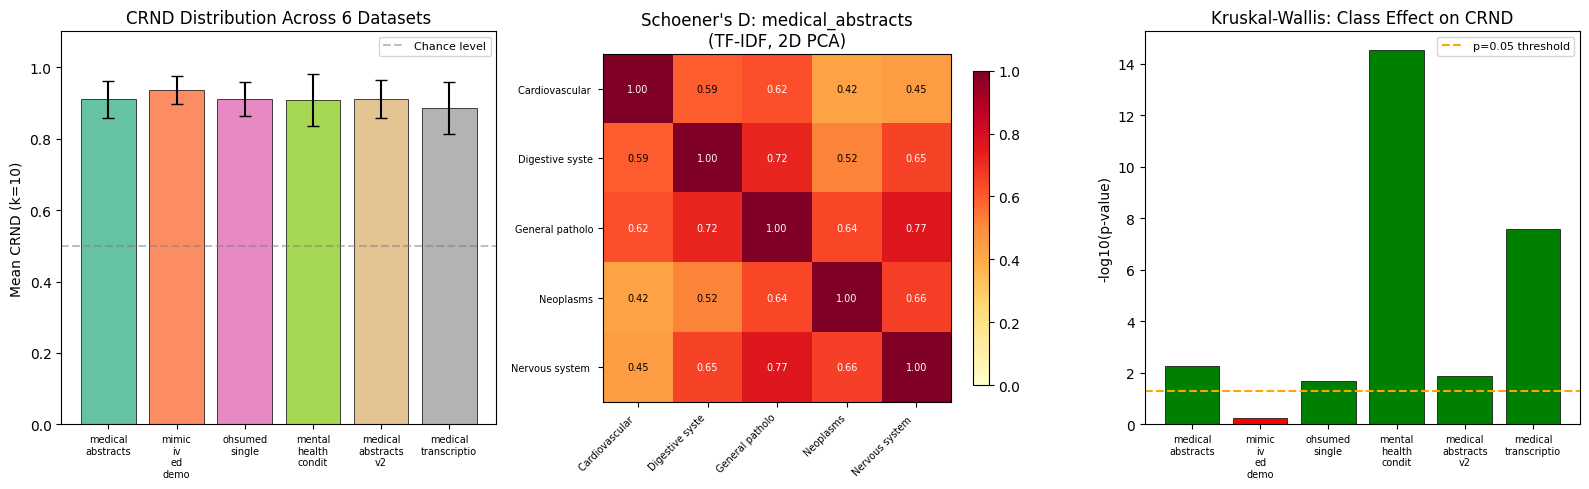


5/6 datasets show significant class effect on CRND (p < 0.05)


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ── Plot 1: CRND Distribution across datasets (k=10) ──
ax = axes[0]
ds_names_short = []
crnd_means = []
crnd_stds = []
for ds_name in datasets_used:
    agg = per_ds_agg[ds_name]
    crnd_s = agg["crnd_summary"]["k10"]
    short_name = ds_name.replace("_", "\n")[:20]
    ds_names_short.append(short_name)
    crnd_means.append(crnd_s["mean"])
    crnd_stds.append(crnd_s["std"])

colors = plt.cm.Set2(np.linspace(0, 1, len(ds_names_short)))
bars = ax.bar(range(len(ds_names_short)), crnd_means, yerr=crnd_stds,
              capsize=4, color=colors, edgecolor="black", linewidth=0.5)
ax.set_xticks(range(len(ds_names_short)))
ax.set_xticklabels(ds_names_short, fontsize=7, ha="center")
ax.set_ylabel("Mean CRND (k=10)")
ax.set_title("CRND Distribution Across 6 Datasets")
ax.set_ylim(0, 1.1)
ax.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5, label="Chance level")
ax.legend(fontsize=8)

# ── Plot 2: Schoener's D Heatmap (medical_abstracts, TF-IDF, 2D) ──
ax = axes[1]
ma_agg = per_ds_agg["medical_abstracts"]
D_mat = np.array(ma_agg["niche_overlap_summary"]["tfidf_pca_2d"]["D_matrix"])
class_names_ma = ma_agg["dataset_info"]["class_names"]
short_cn = [cn.replace("_", " ")[:15] for cn in class_names_ma]
im = ax.imshow(D_mat, cmap="YlOrRd", vmin=0, vmax=1)
ax.set_xticks(range(len(short_cn)))
ax.set_yticks(range(len(short_cn)))
ax.set_xticklabels(short_cn, fontsize=7, rotation=45, ha="right")
ax.set_yticklabels(short_cn, fontsize=7)
ax.set_title("Schoener's D: medical_abstracts\n(TF-IDF, 2D PCA)")
for i in range(len(short_cn)):
    for j in range(len(short_cn)):
        val = D_mat[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7,
                    color="white" if val > 0.6 else "black")
plt.colorbar(im, ax=ax, shrink=0.8)

# ── Plot 3: Kruskal-Wallis significance across datasets ──
ax = axes[2]
kw_pvals = []
kw_names = []
for ds_name in datasets_used:
    agg = per_ds_agg[ds_name]
    pca = agg.get("per_class_analysis", {})
    kw = pca.get("kruskal_wallis", {})
    p = kw.get("p_value", 1.0)
    kw_pvals.append(p)
    kw_names.append(ds_name.replace("_", "\n")[:20])

bars_kw = ax.bar(range(len(kw_names)), [-np.log10(p + 1e-15) for p in kw_pvals],
                 color=["green" if p < 0.05 else "red" for p in kw_pvals],
                 edgecolor="black", linewidth=0.5)
ax.axhline(y=-np.log10(0.05), color="orange", linestyle="--", label="p=0.05 threshold")
ax.set_xticks(range(len(kw_names)))
ax.set_xticklabels(kw_names, fontsize=7, ha="center")
ax.set_ylabel("-log10(p-value)")
ax.set_title("Kruskal-Wallis: Class Effect on CRND")
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

sig_count = sum(1 for p in kw_pvals if p < 0.05)
print(f"\n{sig_count}/{len(kw_pvals)} datasets show significant class effect on CRND (p < 0.05)")

## Visualization: Noise Detection & Cross-Dataset Comparison

Compare noise detection performance (ROC-AUC at 10% noise) across all 6 datasets and feature space overlap rankings.

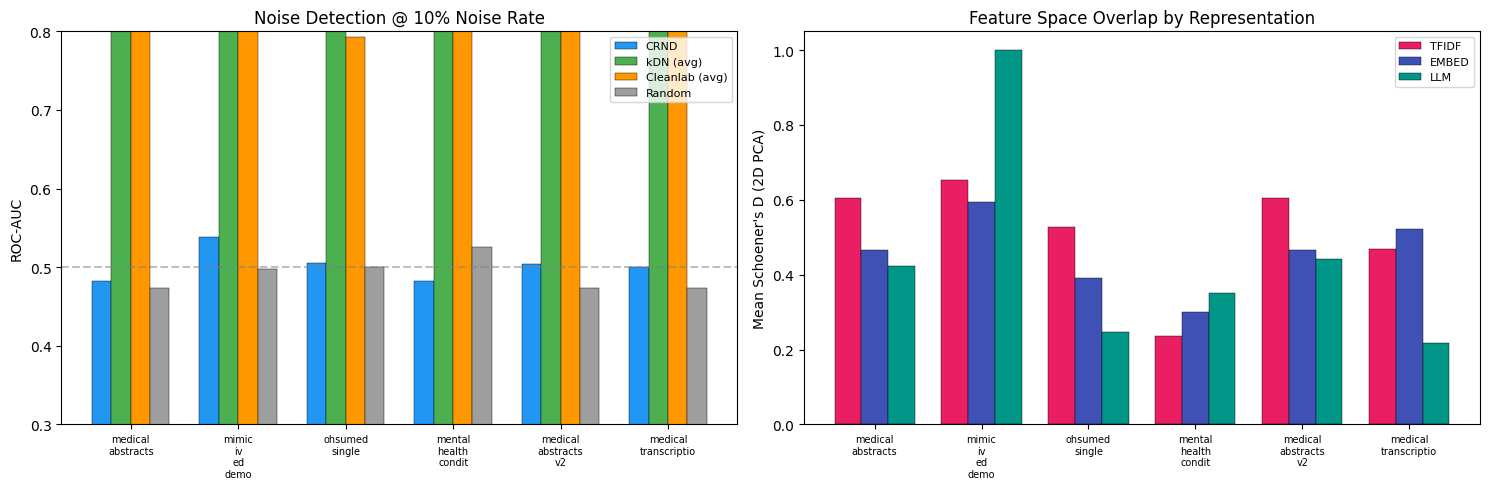


EXPERIMENT SUMMARY
Dataset                       N Classes   CRND k10   KW p-val
----------------------------------------------------------------------
medical_abstracts           300       5     0.9098    0.0055*
mimic_iv_ed_demo            207       4     0.9364    0.5515
ohsumed_single              300      21     0.9113    0.0212*
mental_health_conditions    300       7     0.9069    0.0000*
medical_abstracts_v2        300       5     0.9104    0.0134*
medical_transcriptions      300       5     0.8859    0.0000*
----------------------------------------------------------------------
* = significant at p < 0.05

Success Criteria:
  FAIL: Spearman rho > 0.3 between CRND and injected noise
  PASS: D-gap reveals representation-sensitive class boundaries (nonzero fraction > 0.5)
  PASS: CRND varies significantly across classes (Kruskal-Wallis p < 0.05)


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ── Plot 4: Noise Detection ROC-AUC (10% noise) across datasets ──
ax = axes[0]
methods = ["crnd", "kdn_avg", "cleanlab_avg", "random"]
method_labels = ["CRND", "kDN (avg)", "Cleanlab (avg)", "Random"]
method_colors = ["#2196F3", "#4CAF50", "#FF9800", "#9E9E9E"]

x_pos = np.arange(len(datasets_used))
width = 0.18

for mi, (method, label, color) in enumerate(zip(methods, method_labels, method_colors)):
    aucs = []
    for ds_name in datasets_used:
        nd = per_ds_agg[ds_name].get("noise_detection", {})
        nd_10 = nd.get("0.1", {})
        auc = nd_10.get(method, {}).get("roc_auc_mean", 0.5)
        aucs.append(auc)
    ax.bar(x_pos + mi * width, aucs, width, label=label, color=color,
           edgecolor="black", linewidth=0.3)

ax.set_xticks(x_pos + width * 1.5)
ax.set_xticklabels([d.replace("_", "\n")[:20] for d in datasets_used], fontsize=7)
ax.set_ylabel("ROC-AUC")
ax.set_title("Noise Detection @ 10% Noise Rate")
ax.legend(fontsize=8)
ax.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5)
ax.set_ylim(0.3, 0.8)

# ── Plot 5: Feature Space Overlap Ranking (mean D, 2D PCA) ──
ax = axes[1]
cross_ds = meta.get("cross_dataset_analysis", {})
fs_ranking = cross_ds.get("feature_space_overlap_ranking", {})

space_colors = {"tfidf": "#E91E63", "embed": "#3F51B5", "llm": "#009688"}
x_pos2 = np.arange(len(datasets_used))
width2 = 0.25

for si, space in enumerate(["tfidf", "embed", "llm"]):
    means = []
    for ds_name in datasets_used:
        r = fs_ranking.get(ds_name, {}).get("pca_2d", {})
        means.append(r.get(space, 0.5))
    ax.bar(x_pos2 + si * width2, means, width2, label=space.upper(),
           color=space_colors[space], edgecolor="black", linewidth=0.3)

ax.set_xticks(x_pos2 + width2)
ax.set_xticklabels([d.replace("_", "\n")[:20] for d in datasets_used], fontsize=7)
ax.set_ylabel("Mean Schoener's D (2D PCA)")
ax.set_title("Feature Space Overlap by Representation")
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# ── Summary Table ──
print("\n" + "=" * 70)
print("EXPERIMENT SUMMARY")
print("=" * 70)
print(f"{'Dataset':<25s} {'N':>5s} {'Classes':>7s} {'CRND k10':>10s} {'KW p-val':>10s}")
print("-" * 70)
for ds_name in datasets_used:
    agg = per_ds_agg[ds_name]
    n_inst = agg["dataset_info"]["n"]
    n_cls = agg["dataset_info"]["n_classes"]
    crnd_mean = agg["crnd_summary"]["k10"]["mean"]
    kw_p = agg.get("per_class_analysis", {}).get("kruskal_wallis", {}).get("p_value", 1.0)
    sig = "*" if kw_p < 0.05 else ""
    print(f"{ds_name:<25s} {n_inst:>5d} {n_cls:>7d} {crnd_mean:>10.4f} {kw_p:>9.4f}{sig}")
print("-" * 70)
print("* = significant at p < 0.05")

# Success criteria
sc = meta.get("success_criteria_evaluation", {})
print(f"\nSuccess Criteria:")
for crit_name, crit_data in sc.items():
    met = crit_data.get("met", False)
    desc = crit_data.get("description", crit_name)
    print(f"  {'PASS' if met else 'FAIL'}: {desc}")